# W.1. Equity Indexes and ETFs


In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import seaborn as sns

import sys
sys.path.insert(0, '../cmds')
from utils import *
from portfolio import *

# Equities

## Capital Structure

### Funding

Assets are funded by investors, primarily via one of two types of investor claims:
* debt - senior, fixed (scheduled) claim
* equity - junior, residual claim

This is true of any assets, including
* publicly-listed companies
* privately-listed companies
* private equity funds
* hedge funds

### Stocks

Stocks are equity claims on assets of a corporation.
* Stockholders have a junior claim on the assets and income of the firm.
* Namely, they receive whatever is left over after all other claimants (suppliers, tax collectors, creditors, etc.) have been paid.
* The firm can pay out the residual as dividends or reinvest it in the firm which increases the value of the shares.


### Limited Liability

Limited liability means that shareholders are not accountable for a firm’s obligations.
* Losses are limited to the original investment.
* Equity claim is similar to a call option on a firm’s overall value.
* Compare this to unincorporated businesses where owners are personally liable.

### Market size and ownership

Of all types of capital market securities, stocks have the most market value.
* However, annual new issues are much smaller than that of corporate bonds.
* Annual new issues are less than 1% of the market value of equities.
* About half of stocks are held by individuals. 
* The other half are held by institutional investors such as pension funds, mutual funds, and insurance companies.

## Types of stock
Consider two types of stock.
* **Common stock** is a simple equity claim. It may or may not have voting rights.
* **Preferred stock** is like a hybrid of equity and debt. Like debt, it has no voting rights. 

If no specification is made, “stock” typically refers to common stock, a pure equity claim.

### Preferred stock

Consider some ways preferred is like debt and also equity.
* It has a stated dividend rate, which is similar to a coupon rate on a bond.
* Unlike a bond, the dividend does not have to be paid.
* However, common stockholders cannot be paid dividends until
preferred dividends are paid.
* In fact, usually the cumulative preferred dividend must be paid first.

#### Tax Treatment
Preferred stock has favorable tax treatment, which leads to special demand and supply of it.

### Dual Shares

Some firms have dual share classes, such as an A and B series of shares. Motives include:
- Concentrating control by giving a smaller class much higher voting power
- Ease issues with listing on various exchanges

Examples include Google, Facebook, and Berkshire Hathaway

## Stock Categorization

In trading, it is common to group equities by
- geographical location
- sector
- size 
- style


### Cap

The term "cap" typically refers to **equity capitalization** which is the total **market** value of the firm's equity.

Thus, a stock will be bucketed as **small cap, mid cap, large cap**.

### Sector / Industry
There are a number of common sector/industry classifications.

The Global Industry Classification Standard (GICS) is a popular classification, but there are many.

GICS has a top level of 11 Sectors subdivided by Industry Group, Industry and Sub-Industry.

Reference: https://www.msci.com/our-solutions/indexes/gics

## Style

**Style analysis** refers to grouping stocks by various measures.

### Book Metrics

"Book" measures refer to data from financial reporting (accounting).
- These book measures are not the same as actual market values.
- This is especially important to note for the book value of equity, the *book* capitalization.

#### Financial Statements
- balance sheet
- income statment
- statement of cashflows

#### Earnings
For now, all that will be noted about earnings is that they are a book (accounting) measure of profits, **not an actual cashflow.**

Dividends are an actual market cashflow.

### Book-to-Market

The book-to-market (B/M) ratio is the market value of equity divided by the book (balance sheet) value of equity.

High B/M means strong (accounting) fundamentals per market-value-dollar.
- High B/M are value stocks.
- Low B/M are growth stocks.

### Value and Growth
Many other measures of value based on some cash-flow or accounting value per market price.
- Earnings-price is a popular metric beyond value portfolios. Like B/M, the E/P ratio is accounting value per market valuation.
- EBITDA-price is similar, but uses accounting measure of profit that ignores taxes, financing, and depreciation.
- Dividend-price uses common dividends, but less useful for individual firms as many have no dividends.

Many competing claims to special/better measure of ‘value’.

### Other Styles
Group stocks by
- Price movement. Momentum, mean reversion, etc.
- Volatility. Realized return volatility, market beta, etc.
- Profitability.*
- Investment.*

*As measured in financial statements.

# Returns and Trading

## Common Stock Returns

Unlike bonds, common stocks do NOT have a
* maturity
* (relevant) face value

Rather, the notable features determining returns are
* dividends
* price appreciation

## Dividends

In [10]:
INFILE = f'../data/equity_data.xlsx'
TICK = 'AAPL'
TICKETF = 'SPY'
TICKIDX = 'SPX'

In [11]:
dvds = pd.read_excel(INFILE,sheet_name=f'dividends {TICK}').set_index('record_date')
dvds[dvds['dividend_type']=='Regular Cash'].head(8).style.set_caption(f'Dividends for {TICK}.')

,declared_date,ex_date,payable_date,dividend_amount,dividend_frequency,dividend_type
record_date,,,,,,
2024-02-12 00:00:00,2024-02-01 00:00:00,2024-02-09 00:00:00,2024-02-15 00:00:00,0.240000,Quarter,Regular Cash
2023-11-13 00:00:00,2023-11-02 00:00:00,2023-11-10 00:00:00,2023-11-16 00:00:00,0.240000,Quarter,Regular Cash
2023-08-14 00:00:00,2023-08-03 00:00:00,2023-08-11 00:00:00,2023-08-17 00:00:00,0.240000,Quarter,Regular Cash
2023-05-15 00:00:00,2023-05-04 00:00:00,2023-05-12 00:00:00,2023-05-18 00:00:00,0.240000,Quarter,Regular Cash
2023-02-13 00:00:00,2023-02-02 00:00:00,2023-02-10 00:00:00,2023-02-16 00:00:00,0.230000,Quarter,Regular Cash
2022-11-07 00:00:00,2022-10-27 00:00:00,2022-11-04 00:00:00,2022-11-10 00:00:00,0.230000,Quarter,Regular Cash
2022-08-08 00:00:00,2022-07-28 00:00:00,2022-08-05 00:00:00,2022-08-11 00:00:00,0.230000,Quarter,Regular Cash
2022-05-09 00:00:00,2022-04-28 00:00:00,2022-05-06 00:00:00,2022-05-12 00:00:00,0.230000,Quarter,Regular Cash


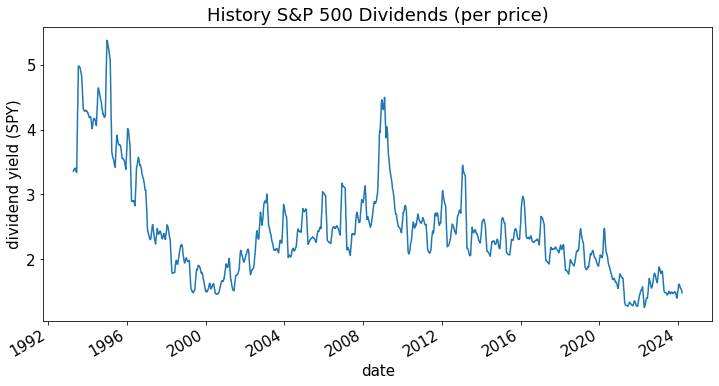

In [12]:
spy = pd.read_excel(INFILE,sheet_name=f'{TICKETF} history').set_index('date')
spy['EQY_DVD_YLD_IND'].rolling(21).mean().plot(title='History S&P 500 Dividends (per price)',ylabel=('dividend yield (SPY)'));

## Corporate Actions

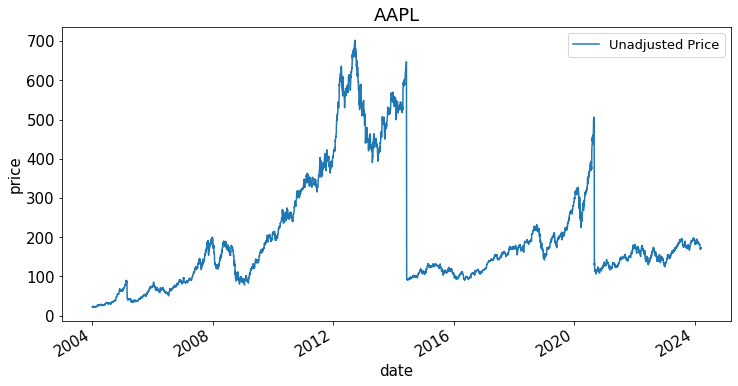

In [13]:
prices = pd.read_excel(INFILE,sheet_name=f'prices {TICK}').set_index('date')

prices['Unadjusted Price'].plot(title=TICK, ylabel='price', legend=['unadjusted price']);

What is going on here? 
- Has Apple really shown so little growth since 2005?
- Has Apple really crashed so hard?

In [14]:
dvds[dvds['dividend_type']=='Stock Split'].rename(columns={'dividend_amount':'split ratio'}).loc[:,['split ratio']].style.set_caption(f'{TICK}')

,split ratio
record_date,
2020-08-24 00:00:00,4.000000
2014-06-02 00:00:00,7.000000
2005-02-18 00:00:00,2.000000
2000-05-19 00:00:00,2.000000
1987-05-15 00:00:00,2.000000


## Adjusted Prices

The **adjusted** price is
* the same as the actual price on the final value of the timeseries.
* readjusted backward through time, so earlier dates may diverge greatly
* ensures a historically accurate return series can be computed

The adjusted price incorporates
* regular dividends
* special dividends
* stock splits

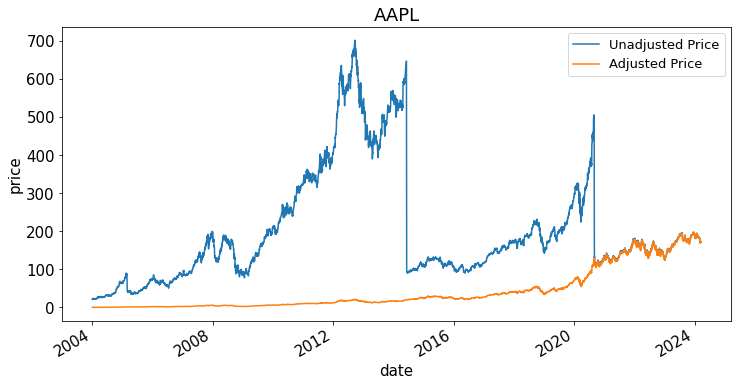

In [15]:
prices[['Unadjusted Price','Adjusted Price']].plot(title=TICK, ylabel='price');

### <span style="background-color:LightSteelBlue">Technical Point: Computation of adjusted price</span>

Notation:
$P$: unadjusted price
$P^*$: adjusted price
$D$: dividend

We want an adjusted price series such that returns are correct, without further adjustment:

$$\frac{P_{t+1} + D_{t+1}}{P_t} = \frac{P_{t+1}^*}{P^*_t}$$

#### Footnote
Adjusted prices (for dividends) are reported in a way that is slightly biased, and does not lead to a completely equivalent return on dividend days. Data providers typically calculate:

$$P^*_t = P_t\prod_{t_i}A_i $$

where the $t_i$ denote the ex-dividend dates such that $t_i > t$. Namely, each dividend causes an additional adjustment factor, $A_i$ for all dates preceding the dividend.

The scaling is given by

$$A_i = 1 - \frac{D_{t_i}}{P_{{t_i}-1}}$$

However, the conversion factor needed to ensure the adjusted series gives identical returns is

$$A_i = \frac{P_{t_i}}{P_{t_i}+D_{t_i}}$$

In practice, this difference is very small, and everyone uses adjusted returns without worrying about this bias.

Still, if you are calculating a dividend-adjusted return by hand from the unadjusted prices, it will not quite match the price growth of the adjusted-price series.

### International Stocks

American Depository Receipts (ADR’s) are certificates traded in U.S. markets which represent foreign stocks.
* ADR’s are used to make it easier for foreign firms to register securities in the U.S.
* Most foreign stocks traded in U.S. markets use ADRs.
* Sometimes, these are called American Depository Shares, or ADS.

***

# Indexes

## The S&P 500

### Constituents

The S&P 500 is composed of 
- US-listed public equities
- Large market cap
- Liquid shares
- A few extra conditions on financials to try to eliminate excess turnover

For practical purposes, consider it as the largest 500 U.S. equities.

Reference: S&P Index methodology, pgs 6-10

https://www.spglobal.com/spdji/en/documents/methodologies/methodology-sp-us-indices.pdf?utm_source=pdf_brochure

In [16]:
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

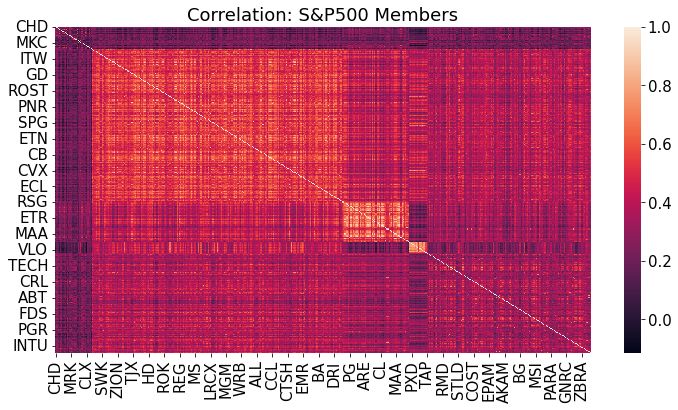

In [17]:
ALTFILE = "../data/spx_returns_weekly.xlsx"
FREQ = 52
rets_spx = pd.read_excel(ALTFILE, sheet_name="s&p500 rets").set_index("date")

sns.heatmap(cluster_corr(rets_spx.corr()))
plt.title('Correlation: S&P500 Members')
plt.show()

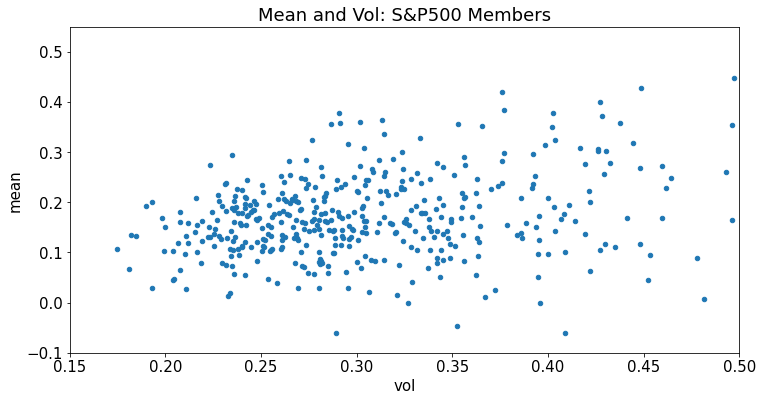

In [18]:
temp = pd.concat([rets_spx.mean()*FREQ, rets_spx.std()*FREQ**.5],axis=1)
temp.columns=['mean','vol']
temp.plot.scatter(x='vol',y='mean',xlim=(.15,.5),ylim=(-.1,.55));
plt.title('Mean and Vol: S&P500 Members');

### There is an outlier over this period

The outlier is ENPH 
- joined the S&P 500 at the end of 2020
- energy firm
- volatile and high-trending returns

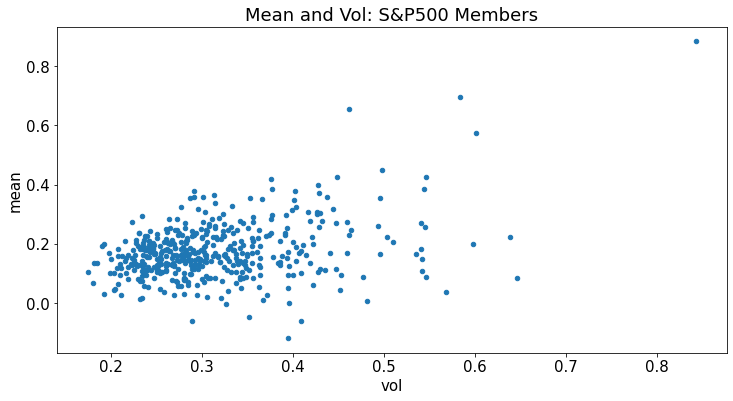

In [19]:
temp.plot.scatter(x='vol',y='mean');
plt.title('Mean and Vol: S&P500 Members');

## Additional U.S. Equity Indexes

Other U.S. equity indexes include many from the S&P:
- S&P 100 - mega cap
- S&P 1500 - large and medium cap
- S&P Sector Indexes

Also consider
- Russell 1000
- Russell 2000
- Wilshire 5000

### Dow Jones Industrial
In financial news, you will often see reference to the Dow Jones Industrial Average (DJIA)
- You will rarely (if ever) use this
- Prominent for historical reasons, but not a good choice for most applications/analysis

Problems with using it include
- Index of only 30 "prominent" equities. 
- Weighting is by price, not by market cap. 
- Turnover may be too slow.

**The DJIA is highly correlated to the S&P500, which is probably the only info of use to us in the index.**

## Exchange-based Indexes

An important set of indexes are those that include stocks trading on a particular **exchange**.

* NYSE Composite (New York)
* NASDAQ Composite (New York)
* FTSE 100 (London)
* Nikkei 225 (Tokyo)
* DAX (German)
* Hang Seng (Hong Kong)

### Additional International Equity Indexes

MSCI indexes provide a wide number of indexes based on global regions and other global designations.

## Style Indexes

There are numerous style indexes used as benchmarks for various types of equity trading strategies.

By far, these indexes focus on
* small vs large (size)
* value vs growth (style)

### Fama-French Factors

The Fama-French Factors serve as popular indexes for these styles.
- Particularly for historical research

Source: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [20]:
index_info = pd.read_excel(INFILE,sheet_name='index info').set_index('ticker')
index_info

,name,count_index_members
ticker,,
SPX,S&P 500 INDEX,503
NYA,NYSE COMPOSITE INDEX,1904
CCMP,NASDAQ COMPOSITE,3382
RIY,RUSSELL 1000 INDEX,1004
RTY,RUSSELL 2000 INDEX,1948
INDU,DOW JONES INDUS. AVG,30
DJITR,DJ INDUSTRIAL AVERAGE TR,30
NKY,NIKKEI 225,225
HSI,HANG SENG INDEX,82


In [21]:
cols_international = ['NKY','HSI','UKX','DAX']
cols_forward = ['NKY','HSI']

indexes = pd.read_excel(INFILE,sheet_name=f'index history').set_index('date')
rets_index = indexes.pct_change().dropna()
rets_index = pd.concat([rets_index.drop(columns=cols_international),rets_index[cols_international]],axis=1)
rets_index[cols_forward] = rets_index[cols_forward].shift(-1)

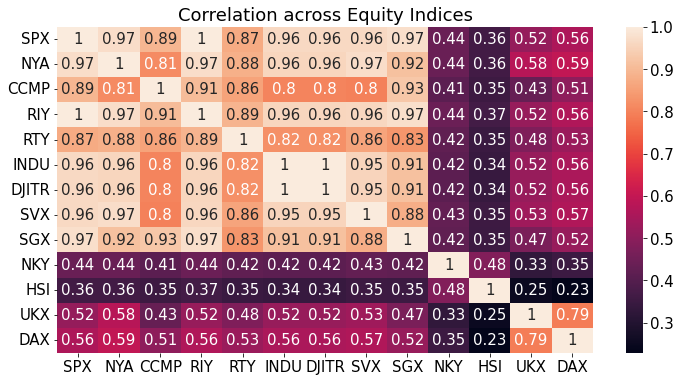

In [22]:
sns.heatmap(rets_index.corr(),annot=True);
plt.title('Correlation across Equity Indices');

***

# Exchange-Traded Funds

An **exchange-traded-fund**
* Trades on a stock exchange
* Shares of the fund which may hold a variety of assets
* Can be traded intra-day

### Questions
* What is an ETF?
* How does an ETF compare to Mutual Funds? 
* Why trade ETF’s?

### History
ETFs Began trading in the U.S. in 1993.
* Active-ETF’s approved in 2008.
* Around 2,000 ETF’s trade in U.S. markets.

### Variety
ETFs include funds
* passively tracking an index of equities
* actively tracking an equity style or trading strategy (smart beta)
* alternative assets

Most ETF’s track an index. ie. S&P 500, U.S. Treasury rate, BBB-AAA credit spread, etc.
* Target wide variety of equity sectors and geographies.
* Funds for a variety of asset classes: equities, oil, grains, credit instruments, etc.
* Active ETF’s tracking a strategy.

Note that the fund expenses and liquidity vary considerably across ETFs.

Consider a few examples.

In [23]:
etf_info = pd.read_excel(INFILE,sheet_name=f'etf info').set_index('ticker')
etf_info[['fund_expense_ratio','eqy_dvd_yld_ind']] /= 100
etf_info.style.format({'fund_expense_ratio':'{:.2%}','eqy_dvd_yld_ind':'{:.2%}'})

,total_number_of_holdings_in_port,fund_expense_ratio,fund_asset_class_focus,fund_objective_long,eqy_dvd_yld_ind
ticker,,,,,
SPY,504,0.09%,Equity,Large-cap,1.24%
UPRO,532,0.92%,Equity,Large-cap,0.71%
EEM,1247,0.70%,Equity,Emerging Markets,3.66%
VGK,1309,0.09%,Equity,European Region,2.23%
EWJ,224,0.50%,Equity,Japan,2.48%
IYR,76,0.40%,Equity,Real Estate,3.48%
DBC,23,0.87%,Commodity,Broad Based,4.74%
HYG,1208,0.49%,Fixed Income,Corporate,6.81%
TIP,52,0.19%,Fixed Income,Inflation Protected,nan%


## Mutual Funds vs ETFs

ETF’s directly trade unit blocks of the assets, for authorized participants.
* Allows intra-day trading.
* No cash-management for redemption, load, fee, etc.
* No direct redemption means favorable capital-gains treatment.

Liquidity
* Reduce idiosyncratic risk.
* Exchange-traded (U.S.)
* Allow for wide variety of trading strategies.

### ETF Share Creation / Redemption

How does an ETF achieve exchange trading? Why doesn't it run into the same issues of a mutual fund?
* Authorized Participants and market-making
* Arbitrage to keep price near NAV

The Greyscale Bitcoin Trust

## Indexes vs ETFs

#### Timing
Above we saw low correlation between equity indexes in the U.S. versus Europe, partly due to asynchronous trading across time-zones.

Below, note that the correlation between SPY, VGK, and EWJ is much higher.

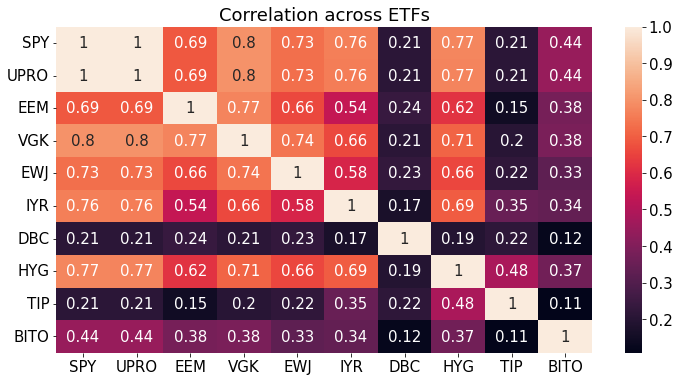

In [24]:
etfs = pd.read_excel(INFILE,sheet_name=f'etf history').set_index('date')
rets_etf = etfs.pct_change().dropna()
sns.heatmap(rets_etf.corr(),annot=True);
plt.title('Correlation across ETFs');

### SPX vs SPY?

If we need a benchmark for a strategy, should we use SPX or SPY?



| Feature               | SPX (S&P 500 Index)                          | SPY (SPDR S&P 500 ETF Trust)            |
|-----------------------|----------------------------------------------|-----------------------------------------|
| **Type**              | Stock Market Index                           | Exchange-Traded Fund (ETF)              |
| **Investment Directly** | No, theoretical only                        | Yes, can be bought and sold like a stock|
| **Trading**           | Options and futures available                | Traded on an exchange like a stock      |
| **Dividends**         | Does not directly pay dividends              | Pays dividends from underlying stocks   |
| **Purpose**           | Benchmark for U.S. stock market performance | Provides investment exposure to the S&P 500 |
| **Management Fees**   | Not applicable                               | Yes, has an expense ratio               |
| **Liquidity**         | Derivatives are liquid; index itself is not | Highly liquid                           |

Why do they seem to have different return statistics below?

Differences in return statistics between SPX and SPY can arise from SPY's expense ratio, dividend handling, cash drag, replication method, market conditions, and dividend taxation, despite SPY's aim to closely track the SPX.

In [30]:
spy_vs_spx = pd.concat([etfs[['SPY']],indexes[['SPX']]],axis=1).dropna().pct_change()
performanceMetrics(spy_vs_spx,annualization=252).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
SPY,11.5%,18.7%,61.3%,-10.9%,14.5%
SPX,9.6%,18.5%,51.9%,-12.0%,11.6%


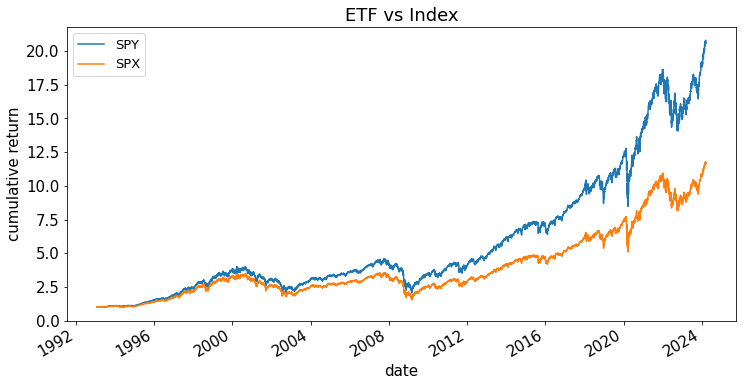

In [31]:
(spy_vs_spx+1).cumprod().plot(title='ETF vs Index',ylabel='cumulative return');

## Levered ETFs

Levered ETFs seek to provide levered exposure to an index, such as the SPX.

These include inverse-levered ETFs.



| Feature               | SPX (S&P 500 Index)                          | SPY (SPDR S&P 500 ETF Trust)            | Leveraged ETFs                           |
|-----------------------|----------------------------------------------|-----------------------------------------|------------------------------------------|
| **Type**              | Stock Market Index                           | Exchange-Traded Fund (ETF)              | Exchange-Traded Fund (ETF) with leverage |
| **Investment Directly**| No, theoretical only                        | Yes, can be bought and sold like a stock| Yes, can be bought and sold like a stock |
| **Trading**           | Options and futures available                | Traded on an exchange like a stock      | Traded on an exchange like a stock       |
| **Dividends**         | Does not directly pay dividends              | Pays dividends from underlying stocks   | May pay dividends, varies by fund        |
| **Purpose**           | Benchmark for U.S. stock market performance | Provides investment exposure to the S&P 500 | Seeks to amplify the returns of the underlying index or benchmark |
| **Management Fees**   | Not applicable                               | Yes, has an expense ratio               | Yes, often higher expense ratios due to the complexity of managing leverage |
| **Liquidity**         | Derivatives are liquid; index itself is not | Highly liquid                           | Generally liquid, but can vary          |
| **Risk Level**        | N/A                                          | Market risk of S&P 500 stocks           | Higher risk due to leverage, potential for amplified losses and gains |



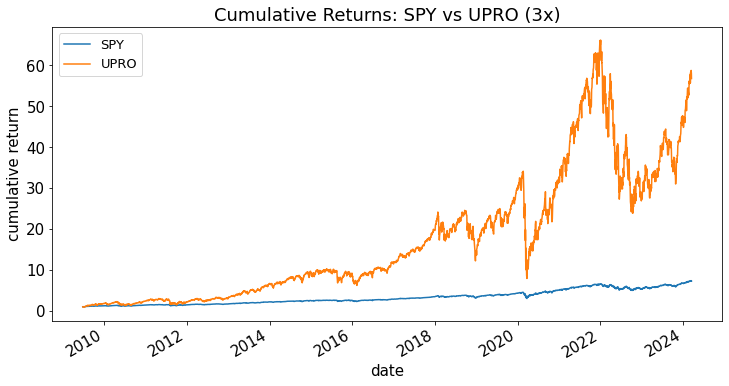

In [32]:
spy_vs_letf = etfs[['SPY','UPRO']].dropna()

temp = (spy_vs_letf.pct_change()+1).cumprod()
temp.plot(title='Cumulative Returns: SPY vs UPRO (3x)',ylabel='cumulative return');

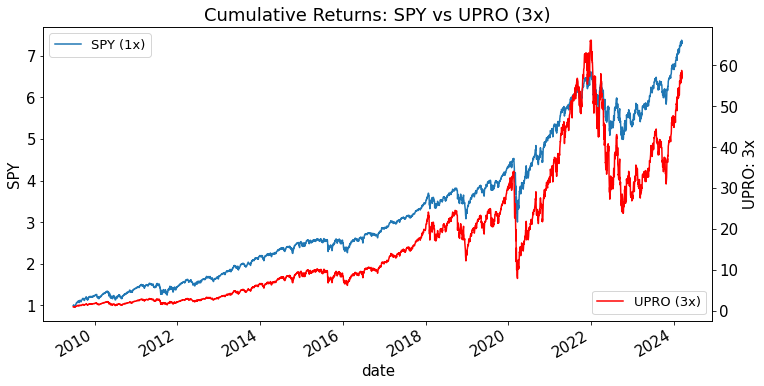

In [33]:
fig, ax = plt.subplots()
temp[['SPY']].plot(ax=ax,ylabel='SPY');
ax.legend(['SPY (1x)'],loc='upper left')
ax2 = plt.twinx(ax=ax)
temp[['UPRO']].plot(ax=ax2,color='r',ylabel='UPRO: 3x');
ax2.legend(['UPRO (3x)'],loc='lower right');
plt.title('Cumulative Returns: SPY vs UPRO (3x)');

In [34]:
performanceMetrics(spy_vs_letf.pct_change(),annualization=252).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
SPY,15.0%,17.2%,87.1%,-10.9%,9.1%
UPRO,41.1%,51.8%,79.4%,-34.9%,28.0%
